In [15]:
# step 1. Імпорт необхідних пакетів

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

# step 2. Завантаження набіру даних Rain in Australia
data = pd.read_csv('C:/Users/Uzivatel/.spyder-py3/weatherAUS.csv')
print(data.shape)
print(data.head())
print(data.dtypes)

(145460, 23)
         Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
0  2008-12-01   Albury     13.4  ...     21.8         No            No
1  2008-12-02   Albury      7.4  ...     24.3         No            No
2  2008-12-03   Albury     12.9  ...     23.2         No            No
3  2008-12-04   Albury      9.2  ...     26.5         No            No
4  2008-12-05   Albury     17.5  ...     29.7         No            No

[5 rows x 23 columns]
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday    

In [16]:
# step 3. Коректне розділення набору даних на тренувальну і тестову вибірки

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64


C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_8484\216970826.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = (data.groupby('Location').apply(lambda x: x.drop(['Location', 'Date'], axis=1).isna().mean()))


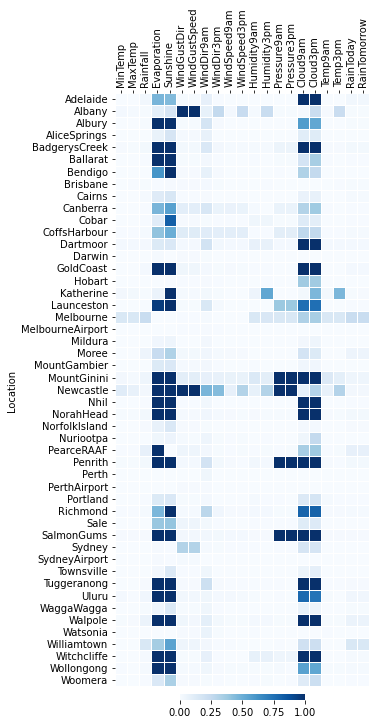

         Date Location  MinTemp  ...  Temp3pm  RainToday RainTomorrow
0  2008-12-01   Albury     13.4  ...     21.8         No           No
1  2008-12-02   Albury      7.4  ...     24.3         No           No
2  2008-12-03   Albury     12.9  ...     23.2         No           No
3  2008-12-04   Albury      9.2  ...     26.5         No           No
4  2008-12-05   Albury     17.5  ...     29.7         No           No

[5 rows x 19 columns]


In [17]:
# step 3.1. Видалення ознак з великою кількістю пропущених значень
    
# Перевірка на наявність пропущених значень
print(data.isna().mean().sort_values(ascending=False))

tmp = (data.groupby('Location').apply(lambda x: x.drop(['Location', 'Date'], axis=1).isna().mean()))
plt.figure(figsize=(9, 13))
ax = sns.heatmap(tmp, cmap='Blues', linewidth=0.5, square=True, cbar_kws=dict(location="bottom", pad=0.01, shrink=0.25))
ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Також видалимо спостереження, для яких відсутня цільова мітка (пропуски в колонці RainTomorrow).
data = data[data.columns[data.isna().mean().lt(0.35)]]
data = data.dropna(subset='RainTomorrow')

# Видаляємо ознаки з більше ніж 30% пропущених значень
# Це дозволить зберегти тільки ті колонки, які мають достатню кількість даних для аналізу.
# Якщо залишити колонки з великою кількістю пропусків,
# то будь-яка методологія заповнення цих пропусків може внести упередження в модель.
data = data[data.columns[data.isnull().mean() < 0.3]]

print(data.head())

In [ ]:
# step 3.2. Створення підмножин набору даних із числовими та категоріальними ознаками

# Огляд даних за типами
data_num = data.select_dtypes(include=['number'])
data_cat = data.select_dtypes(include=['object'])

g = sns.FacetGrid(data_num.melt(), col='variable', col_wrap=4, sharex=False, sharey=False, aspect=1.25)
g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

# Рахуємо кількість унікальних категорій за кожною колонкою
print(data_cat.nunique())
print(data_cat.apply(lambda x: x.unique()[:5]))

In [ ]:
# step 3.3. Зміна типу колонки Date на datetime і створення додаткових колонок Year та Month
# Перетворення колонки 'Date' на datetime формат
data['Date'] = pd.to_datetime(data['Date'])

# Створення колонок 'Year' і 'Month' на основі 'Date'
data['Year'] = data['Date'].dt.year.astype(int)
data['Month'] = data['Date'].dt.month.astype(str)

# %% 
# step 3.4 Переміщення колонки Year до числових ознак
data_num = data.select_dtypes(include=['number'])
data_cat = data.select_dtypes(include=['object'])
data_cat = data_cat.drop(columns=['RainTomorrow'])

# Перевірка результату
print("Числові колонки:", data_num.columns)
print("Категоріальні колонки:", data_cat.columns)

In [ ]:
# step 3.5. Розбиття на тренувальну і тестову вибірки 

# за такою логікою: до тестової вибірки віднесіть всі об'єкти із набору даних із максимальним роком спостережень,
# а для навчання моделі залишити всі інші об'єкти.
# Визначення року для тестової вибірки
test_year = data['Year'].max()

# Розділення на тренувальну та тестову вибірки
train_df = data[data['Year'] < test_year]
test_df = data[data['Year'] == test_year]

# Оновлення числових і категоріальних ознак після розділення на train та test
X_train_num = data_num[data['Year'] < test_year]
X_train_cat = data_cat[data['Year'] < test_year]
y_train = train_df['RainTomorrow']

X_test_num = data_num[data['Year'] == test_year]
X_test_cat = data_cat[data['Year'] == test_year]
y_test = test_df['RainTomorrow']

# Перевірка правильності виконання
print(X_train_num.head())
print(X_train_cat.head())

In [ ]:
# step 4. Відновлення пропущених даних за допомогою SimpleImputer

# Є декілька методів, як можна відновити дані: mean, median, most_frequent, constant
# Числові дані не містять значних викидів та не мають розподіл із сильним перекосом,
# тому краще використовувати mean замість median
trans_num = SimpleImputer(strategy='mean')
X_train_num = trans_num.fit_transform(X_train_num)
X_test_num = trans_num.transform(X_test_num)

# У той час, категоріальні дані мають декілька унікальних значень, тому метод most_frequent не вплине на розподіл.
trans_cat = SimpleImputer(strategy='most_frequent')
X_train_cat = trans_cat.fit_transform(X_train_cat)
X_test_cat = trans_cat.transform(X_test_cat)


In [ ]:
# step 5. Нормалізація числових ознак за допомогою StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [ ]:
# step 6. Кодування категоріальних ознак за допомогою OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder_cat.fit_transform(trans_cat.fit_transform(X_train_cat))
X_test_cat = encoder_cat.transform(trans_cat.transform(X_test_cat))

In [11]:
# step 7. Об'єднання підмножин та побудова моделі
# Об'єднання числових та категоріальних ознак
X_train = pd.concat([pd.DataFrame(X_train_num), pd.DataFrame(X_train_cat)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_num), pd.DataFrame(X_test_cat)], axis=1)

# Навчання моделі логістичної регресії
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Прогнозування на тестових даних
y_pred = model.predict(X_test)

In [12]:
# step 8. Розрахунок метрик та порівняння
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.87      0.95      0.91      6703
         Yes       0.71      0.44      0.55      1763

    accuracy                           0.85      8466
   macro avg       0.79      0.70      0.73      8466
weighted avg       0.84      0.85      0.83      8466



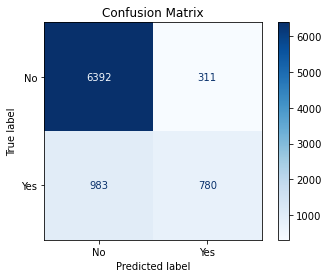

In [13]:
# Побудова Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

C:\Users\Uzivatel\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Uzivatel\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


              precision    recall  f1-score   support

          No       0.92      0.82      0.86      6703
         Yes       0.51      0.72      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.71      0.77      0.73      8466
weighted avg       0.83      0.80      0.81      8466



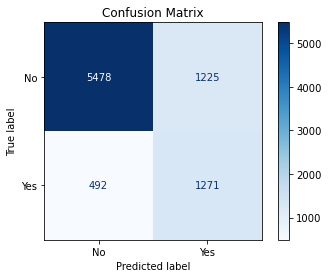

In [14]:
# Балансування даних за допомогою SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Навчання моделі логістичної регресії
model = LogisticRegression(solver='liblinear')
model.fit(X_train_balanced, y_train_balanced)

# Прогнозування на тестових даних
y_pred = model.predict(X_test)

# %%
# step 8. Розрахунок метрик та порівняння
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Побудова Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Оцінка результатів

Балансування класів покращує здатність моделі передбачати рідкісні події, такі як дощ. Однак це приходить з певними компромісами в точності передбачень відсутності дощу. Висока кількість False Positives може призводити до того, що модель часто рекомендує брати парасольку, навіть коли це не потрібно.

## Без балансування класів
**Висока точність для випадків, коли не йде дощ "No"** -> Точність (0.87) і F1-Score (0.91) дає розуміння, що модель добре передбачає дану категорію.

**Низька повнота для випадків, коли йде дощ "Yes"** -> Модель пропускає багато позитивних випадків, бо чутливість (0.44) для цього класу є низькою.

**Macro Ave** показує середні результати для кожного класу, що допомагає зрозуміти загальну продуктивність моделі по обох класах.

(precision - 0.79; recall - 0.70; f1-score - 0.73)

**Weighted Ave** ця метрика дає уявлення про те, як модель справляється з даними в загальному випадку, з урахуванням дисбалансу класів.

(precision - 0.84; recall - 0.85; f1-score - 0.83)

### Висновки Confusion Matrix

**TP (True Positives)**: 780 — модель передбачила, що дощ був

**TN (True Negatives)**: 6392 — модель передбачила, що дощу не було

**FP (False Positives)**: 311 — модель помилково передбачила дощ, коли його не було

**FN (False Negatives)**: 983 — модель не передбачила дощ, але насправді дощ був


## З балансуванням класів
**Коли не йде дощ "No"** -> 0.92 це значно краще значення, що вказує на високу точність передбачень відсутності дощу.

**Коли йде дощ "Yes"** -> Балансування класів покращує здатність моделі передбачати дощ. Хоча точність для класу "Yes" (0.51) не є високою, модель стала менш упередженою, і точність передбачень дощу зросла.

**Macro Ave** Показники Precision (0.71), Recall (0.77) та F1-score (0.73) вказують на збалансованішу роботу моделі з обома класами, хоч і з трохи гіршими результатами для кожного класу окремо.

**Weighted Ave** ця метрика дає уявлення про те, як модель справляється з даними в загальному випадку (Precision - 0.83; Recall - 0.80; F1-score - 0.81)

### Висновки Confusion Matrix

**TP (True Positives)**: 1271 — модель передбачила, що дощ був

**TN (True Negatives)**: 5478 — модель передбачила, що дощу не було

**FP (False Positives)**: 1225 — модель помилково передбачила дощ, коли його не було

**FN (False Negatives)**: 492 — модель не передбачила дощ, але насправді дощ був